In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [ ]:
#Load Dataset
df = pd.read_excel('/content/Copy of online_retail_II.xlsx')

In [ ]:
# Display Dataset Info
print("Dataset Shape:", df.shape)
print("Dataset Overview:\n", df.head())


Dataset Shape: (525461, 8)
Dataset Overview:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [ ]:
#Calculating Missing Values:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,2928
Quantity,0
InvoiceDate,0
Price,0
Customer ID,107927
Country,0


In [ ]:
#Removing Missing Values:
df = df.dropna()
print(df)

       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID         Country  
0      2009-12-01 07:45:00   6.95 

In [ ]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [ ]:
# Add a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']


In [ ]:
print(df)

       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID         Country  TotalPrice  
0      2009-12-01 07:4

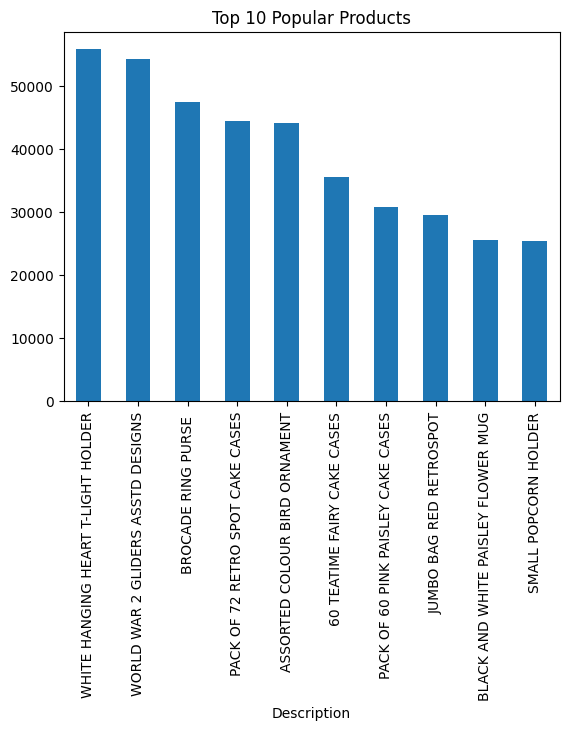

In [ ]:
# Visualize Product Popularity
popular_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
popular_products.plot(kind='bar', title='Top 10 Popular Products')
plt.show()

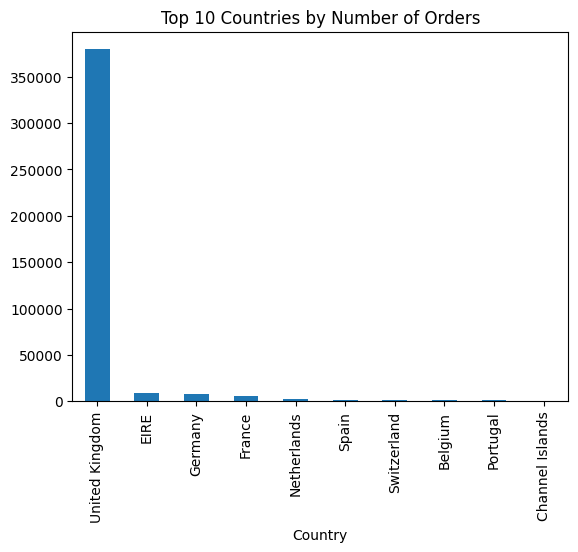

In [ ]:
# Distribution of Orders by Country
country_orders = df['Country'].value_counts().head(10)
country_orders.plot(kind='bar', title='Top 10 Countries by Number of Orders')
plt.show()

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_data = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalPrice': 'sum'
})
customer_data.columns = ['Recency', 'Frequency', 'Monetary']

In [ ]:

# Filter out customers with Monetary <= 0
customer_data = customer_data[customer_data['Monetary'] > 0]


In [ ]:
print(customer_data)

             Recency  Frequency  Monetary
Customer ID                              
12347.0            3         71   1323.32
12348.0           74         20    222.16
12349.0           43        107   2646.99
12351.0           11         21    300.93
12352.0           11         18    343.80
...              ...        ...       ...
18283.0           18        230    641.77
18284.0           65         29    436.68
18285.0          296         12    427.00
18286.0          112         70   1188.43
18287.0           18         86   2340.61

[4283 rows x 3 columns]


In [ ]:
# Step 3: Preprocessing for Clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

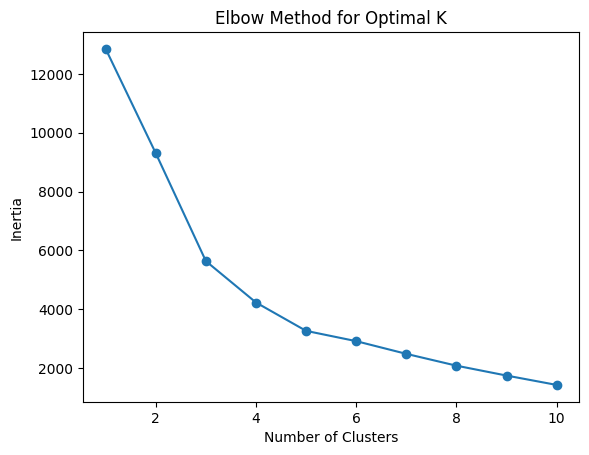

In [ ]:
# Step 4: KMeans Clustering
def find_optimal_clusters(data, k_range):
    inertia = [KMeans(n_clusters=k, random_state=42).fit(data).inertia_ for k in k_range]
    plt.plot(k_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()
    return inertia

# Elbow method to find number of clusters
k_range = range(1, 11)
inertia = find_optimal_clusters(scaled_data, k_range)

# Optimal number of clusters
optimal_k = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)


In [ ]:
print(customer_data.groupby('Cluster').mean())

            Recency    Frequency       Monetary
Cluster                                        
0         42.795665    87.058336    1548.662148
1        241.807960    29.958209     519.065039
2         13.759124   749.759124   15741.330241
3          4.750000  2715.000000  226621.560000


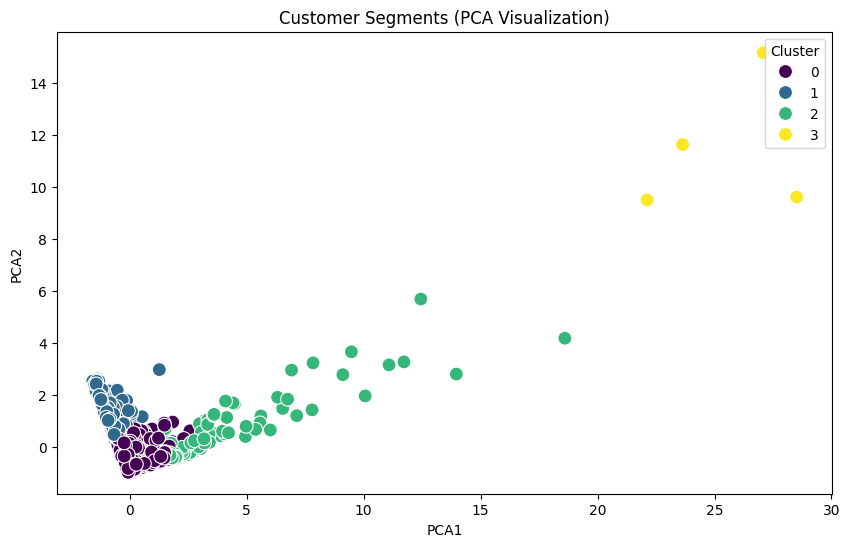

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_data['PCA1'] = pca_data[:, 0]
customer_data['PCA2'] = pca_data[:, 1]

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=100)
plt.title('Customer Segments (PCA Visualization)')
plt.show()


In [ ]:
# Step 6: Insights and Recommendations

# For various clusters
cluster_analysis = customer_data.groupby('Cluster').mean()
print("Cluster Analysis:\n", cluster_analysis)


Cluster Analysis:
             Recency    Frequency       Monetary       PCA1       PCA2
Cluster                                                              
0         42.795665    87.058336    1548.662148   0.122080  -0.459911
1        241.807960    29.958209     519.065039  -0.949505   1.333412
2         13.759124   749.759124   15741.330241   3.430139   0.414168
3          4.750000  2715.000000  226621.560000  25.339366  11.480246


Analyzing Product Demand and Sales:

Root Mean Squared Error: 119157.8486458707


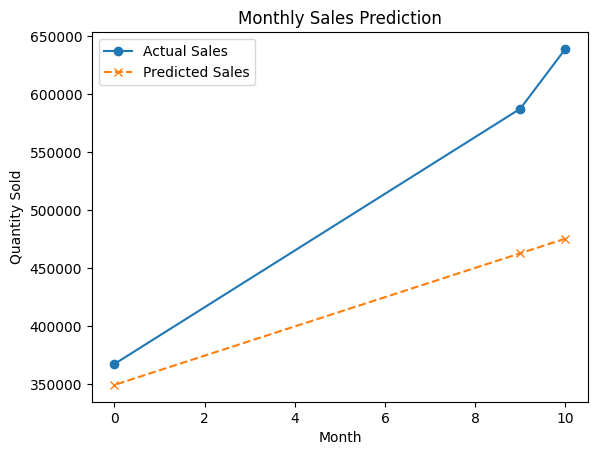

In [61]:


# 1. Create new columns for Date Features
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['DayOfMonth'] = df['InvoiceDate'].dt.day

# 2. Aggregate sales by month
monthly_sales = df.groupby('Month')['Quantity'].sum().reset_index()
monthly_sales.columns = ['Month', 'Quantity']

# 3. Prepare feature and target variables
X = monthly_sales[['Month']]  # Using Month as the feature
y = monthly_sales['Quantity']  # Target variable (Quantity sold)

# 4. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict on test data
y_pred = model.predict(X_test)

# 7. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# 8. Plot the predictions vs actual values
plt.plot(y_test.index, y_test, label='Actual Sales', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Sales', linestyle='--', marker='x')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.title('Monthly Sales Prediction')
plt.legend()
plt.show()


In [ ]:
# Inventory Turnover = Total Quantity Sold / Average Inventory
product_demand['Turnover_Rate'] = product_demand['Total_Sold'] / product_demand['Sales_Count']

# Identify slow-moving items (low turnover rate)
slow_moving_items = product_demand[product_demand['Turnover_Rate'] < product_demand['Turnover_Rate'].quantile(0.25)]
print("Slow Moving Items:\n", slow_moving_items)


Slow Moving Items:
                                      Total_Sold  Sales_Count  Turnover_Rate
Description                                                                
BAKING SET 9 PIECE RETROSPOT               3462         1082       3.199630
REX CASH+CARRY JUMBO SHOPPER               2220         1195       1.857741
POSTAGE                                    2075          822       2.524331
RETRO SPOT LARGE MILK JUG                  1588          498       3.188755
RED SPOTTY ROUND CAKE TINS                 1393          438       3.180365
...                                         ...          ...            ...
TREE OF NOAH FESTIVE SCENTED CANDLE         -34           11      -3.090909
LARGE RED RETROSPOT WINDMILL                -64           78      -0.820513
SILVER CHERRY LIGHTS                        -96           31      -3.096774
WHITE CHERRY LIGHTS                         -97          216      -0.449074
Discount                                  -1675           97     -17

Purchase Frequency:
 count    4383.000000
mean        5.381474
std        10.051921
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       270.000000
Name: Invoice, dtype: float64


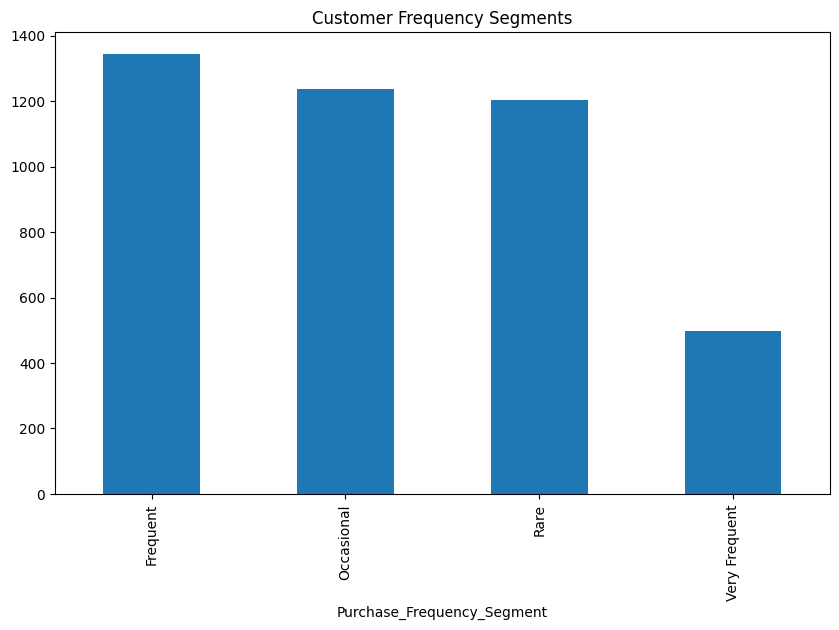

In [ ]:
# Purchase frequency
purchase_frequency = df.groupby('Customer ID')['Invoice'].nunique()
print("Purchase Frequency:\n", purchase_frequency.describe())

# Segment customers by frequency
bins = [0, 1, 3, 10, float('inf')]
labels = ['Rare', 'Occasional', 'Frequent', 'Very Frequent']
customer_data['Purchase_Frequency_Segment'] = pd.cut(purchase_frequency, bins=bins, labels=labels)

# Visualize segments
customer_data['Purchase_Frequency_Segment'].value_counts().plot(kind='bar', title='Customer Frequency Segments', figsize=(10, 6))
plt.show()


<Figure size 1000x600 with 0 Axes>

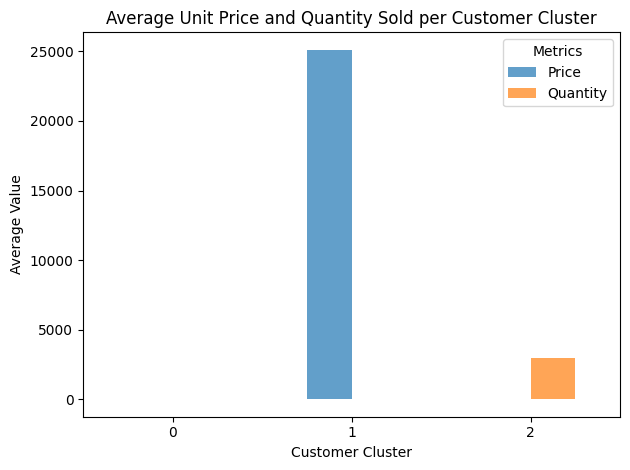

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming df contains 'Price', 'Customer ID', and 'Quantity' or other relevant columns

# Feature Engineering: We are going to cluster based on Price and Quantity sold
df_grouped = df.groupby('Customer ID')[['Price', 'Quantity']].mean().reset_index()  # Group by Customer ID

# Normalize the features before clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_grouped[['Price', 'Quantity']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_grouped['Cluster'] = kmeans.fit_predict(df_scaled)

# Aggregate data by cluster
cluster_summary = df_grouped.groupby('Cluster')[['Price', 'Quantity']].mean().reset_index()

# Visualizing the results with a bar chart
plt.figure(figsize=(10, 6))
cluster_summary.set_index('Cluster')[['Price', 'Quantity']].plot(kind='bar', alpha=0.7)
plt.title('Average Unit Price and Quantity Sold per Customer Cluster')
plt.xlabel('Customer Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


In [57]:

# Average Daily Sales and Lead Time
df['DailySales'] = df['Quantity'] / (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days
lead_time = 7  # Assume 7 days lead time

# Reorder Point for Each Product
df['ReorderPoint'] = df['DailySales'] * lead_time

# Display Products Close to Reorder Point
low_stock = df[df['Quantity'] < df['ReorderPoint']]
print(low_stock[['Description', 'Quantity', 'ReorderPoint']])


                             Description  Quantity  ReorderPoint
178             PAPER BUNTING WHITE LACE       -12     -0.225201
179         CREAM FELT EASTER EGG BASKET        -6     -0.112601
180        POTTING SHED SOW 'N' GROW SET        -4     -0.075067
181                   POTTING SHED TWINE        -6     -0.112601
182           PAPER CHAIN KIT RETRO SPOT       -12     -0.225201
...                                  ...       ...           ...
524695          36 FOIL HEART CAKE CASES        -2     -0.037534
524696                            Manual        -4     -0.075067
524697  ROSES REGENCY TEACUP AND SAUCER         -1     -0.018767
524698          REGENCY CAKESTAND 3 TIER        -1     -0.018767
525282       SET OF 3 BLACK FLYING DUCKS        -1     -0.018767

[9839 rows x 3 columns]


<ipython-input-65-634d7d3ff07f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')


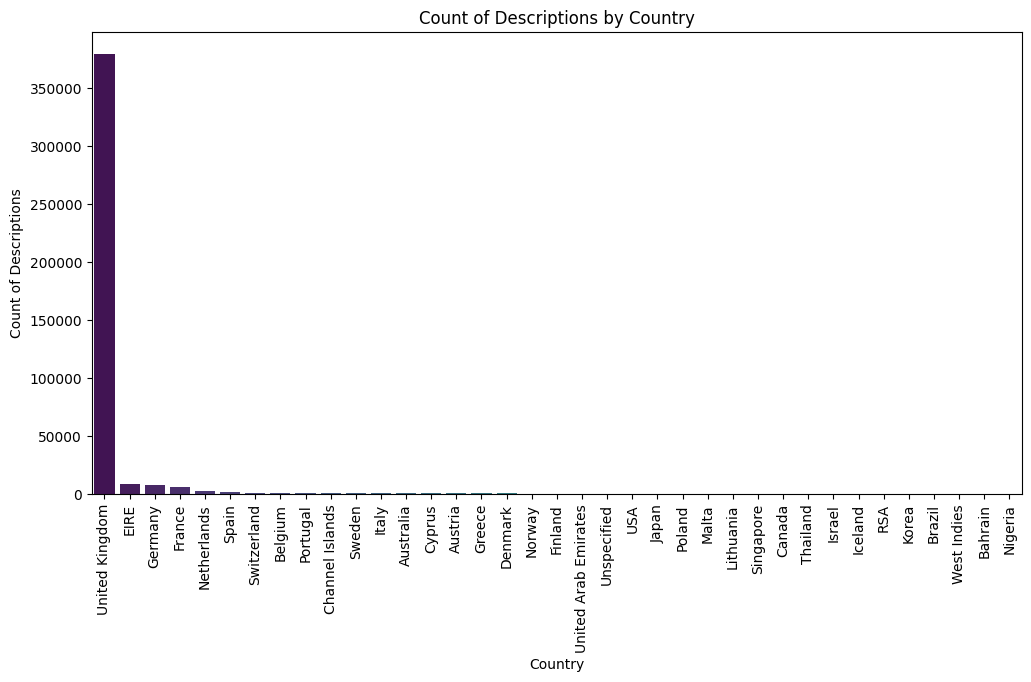

In [65]:
country_counts = df['Country'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title('Count of Descriptions by Country')
plt.xlabel('Country')
plt.ylabel('Count of Descriptions')
plt.xticks(rotation=90)
plt.show()

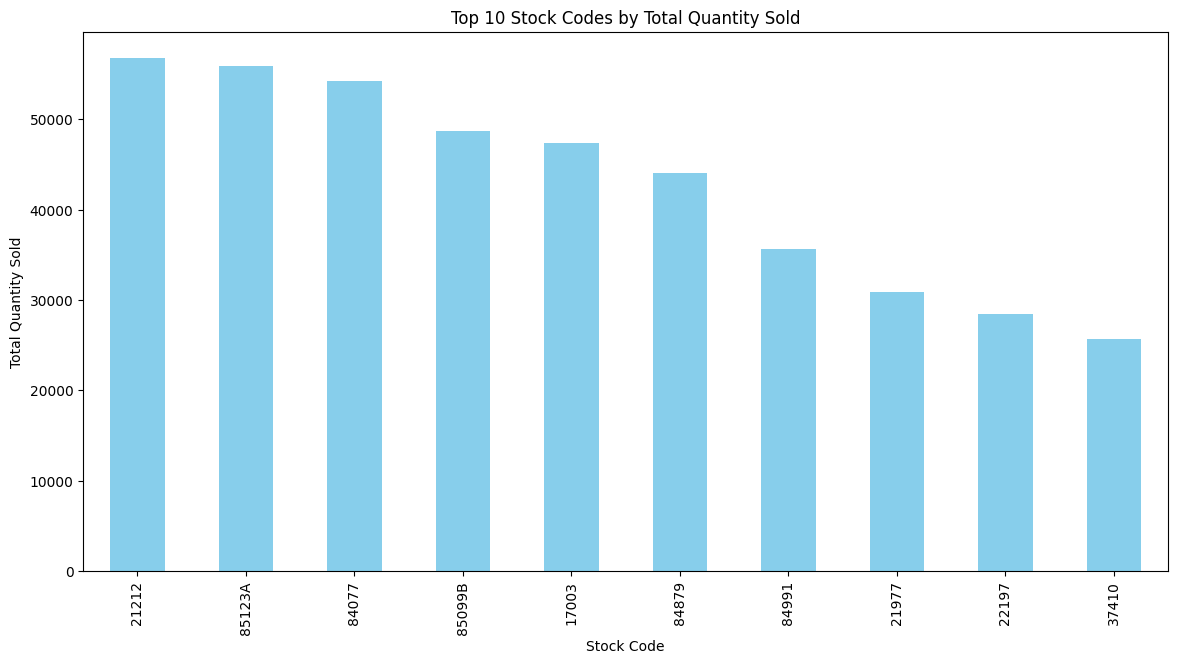

In [70]:
stock_quantity_sum = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)  # Top 10 stock codes
plt.figure(figsize=(14, 7))
stock_quantity_sum.plot(kind='bar', color='skyblue')
plt.title('Top 10 Stock Codes by Total Quantity Sold')
plt.xlabel('Stock Code')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.show()

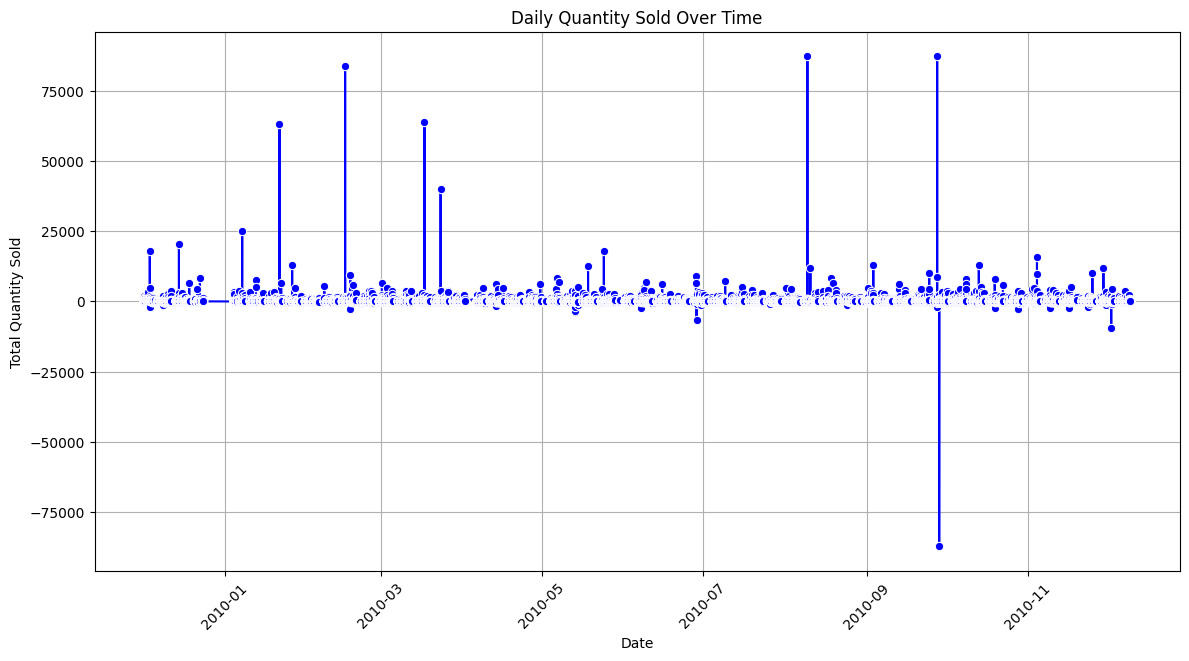

In [71]:
daily_quantity = df.groupby('InvoiceDate')['Quantity'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x='InvoiceDate', y='Quantity', data=daily_quantity, marker='o', color='blue')
plt.title('Daily Quantity Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid()
plt.show()

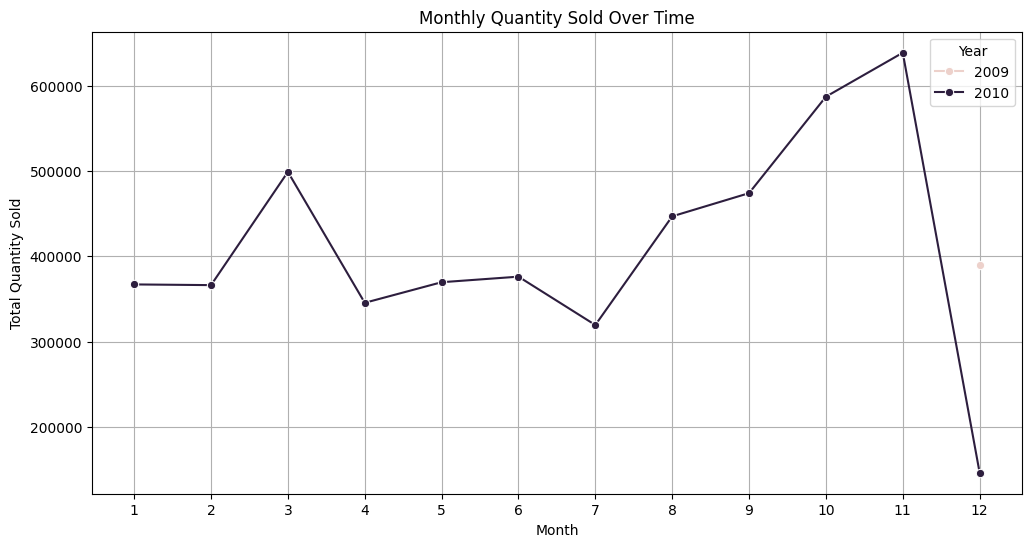

In [73]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Step 2: Extract relevant components from 'InvoiceDate' (e.g., month, day, year)
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Weekday'] = df['InvoiceDate'].dt.weekday  # Monday=0, Sunday=6

# Step 3: Plot total Quantity sold per month
monthly_quantity = df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Quantity', data=monthly_quantity, hue='Year', marker='o')
plt.title('Monthly Quantity Sold Over Time')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid()
plt.show()